In [19]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import shutil

SEED = 0xF1C4

tf.random.set_seed(SEED)
np.random.seed(SEED)


USE_GRAYSCALE = False
USE_SATURATION = False
apply_data_augmentation = True


img_w = 128
img_h = 128

target_shape = [img_w, img_h, 1 if USE_GRAYSCALE else 3]

In [20]:

CWD = os.getcwd()

def fcwd(path):
    return os.path.join(CWD, path)

def makeValidationSet(dataset_dir, dest_base, train_dir ='training', perc = 0.1):
    
    import os
    import shutil
    import numpy
    
    dest_dir = os.path.join(dest_base, 'validation')
    train_dir = os.path.join(dataset_dir, train_dir)
    
    print("valid dest: "+ str(dest_dir))
    print("train dir: "+ str(train_dir))
    
    # create folder if not preset
    if not os.path.exists(dest_dir):
        os.mkdir(dest_dir)
        
    # split for every class
    for class_dir in os.listdir(train_dir):     
        curr_dir = os.path.join(dest_dir, class_dir)
        curr_train_dir = os.path.join(train_dir, class_dir)
        
        # create current folder in validation folder
        if not os.path.exists(curr_dir):
            os.mkdir(curr_dir) 
        
        #calculate how many items must be moved
        items = os.listdir(curr_train_dir)
        num_to_move = int(len(items) * perc)
        
        
        for i in range(num_to_move):
            items = os.listdir(curr_train_dir)  # update item count after move
            idx = numpy.random.randint(0, len(items))
            
            frm = os.path.join(curr_train_dir, items[idx])
            to = os.path.join(curr_dir,items[idx])
            print("Moved "+str(frm)+" to "+ to)
            
            shutil.move(frm, to)
            
    print("Validation set generated")
    
    

dataset_dir = fcwd('data')


train_dest = os.path.join(dataset_dir, 'training')
valid_dest =  os.path.join(dataset_dir, 'validation')

print(CWD)
print(dataset_dir)
print(train_dest)
print(valid_dest)


if not os.path.exists(fcwd('data/splitted')):
    # read classes from json
    import json
    f = open(os.path.join(dataset_dir, 'train_gt.json'),'r').read()
    image_dictionary = json.loads(f) # dictionary with image: class
    classes = ['0','1','2']


    # create 0,1,2 sub folders
    for c in classes:
        os.mkdir(os.path.join(train_dest,c))

        import shutil

    zero_dir = os.path.join(train_dest,'0')
    one_dir = os.path.join(train_dest,'1')
    two_dir = os.path.join(train_dest,'2')

    # move photos in the correct folder
    for key in image_dictionary:
        if image_dictionary[key] == 0:
            shutil.move(os.path.join(train_dest,key),os.path.join(zero_dir,key))
        if image_dictionary[key] == 1:
            shutil.move(os.path.join(train_dest,key),os.path.join(one_dir,key))
        if image_dictionary[key] == 2:
            shutil.move(os.path.join(train_dest,key),os.path.join(two_dir,key))
    # create validation set
    makeValidationSet(dataset_dir, dest_base=dataset_dir, perc=0.20)

    open(fcwd('data/splitted'), 'a').close() # create empty file marker to skip this process
    print("Splitted dataset")
else:
    print("Dataset is ready splitted")

f:\Develop\scassorflow
f:\Develop\scassorflow\data
f:\Develop\scassorflow\data\training
f:\Develop\scassorflow\data\validation
Dataset is ready splitted


In [21]:
checkpoint_dir = fcwd('checkpoints')

if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

os.mkdir(checkpoint_dir)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# prepare for data augmentation
#from tensorflow.keras.applications.vgg16 import preprocess_input

if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=5,
        height_shift_range=5,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant', # fill new pixels generatend by transformation with cval
        cval=0,
        rescale=1/255., # scale values to [0,1]  
        #preprocessing_function=preprocess_input  
        )
else:
    train_data_gen = ImageDataGenerator(
        rescale=1/255.0,
        #preprocessing_function=preprocess_input
        )

valid_data_gen = ImageDataGenerator(
        #preprocessing_function=preprocess_input
        rescale=1/255.0,
        )


In [23]:

# prepare directory paths

bs = 16

# prepere loader
train_gen = train_data_gen.flow_from_directory(
   train_dest, 
   batch_size=bs,
   class_mode='categorical',
   shuffle=True,
   seed=SEED,
   target_size=(img_w, img_h),
   color_mode= 'grayscale' if USE_GRAYSCALE else 'rgb'
   )

valid_gen = valid_data_gen.flow_from_directory(
    valid_dest, 
    batch_size=bs,
    class_mode='categorical',
    shuffle=True,
    seed=SEED,
    target_size=(img_w, img_h),
    color_mode= 'grayscale' if USE_GRAYSCALE else 'rgb'
    )


Found 4492 images belonging to 3 classes.
Found 1122 images belonging to 3 classes.


In [24]:
#create datasets


in_shape = [None] + target_shape


print("Input shape: " + str(in_shape))

n_classes = train_gen.num_classes  # search how to deduct from load
print("Available classes: "+str(n_classes))

out_shape = (in_shape, [None, n_classes])
print("Generator output shape: "+str(out_shape))



train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),       # matrix value types
                                               output_shapes=out_shape  #output shapes ( image - label )
                                               )

train_dataset = train_dataset.repeat() # make traning continue after first epoch

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32), 
                                               output_shapes=out_shape 
                                               )


test_dataset = tf.data.Dataset.from_generator(lambda: test_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=out_shape 
                                               )

valid_dataset = valid_dataset.cache()
train_dataset = train_dataset.cache()

print(train_dataset)
print(valid_dataset)

Input shape: [None, 128, 128, 3]
Available classes: 3
Generator output shape: ([None, 128, 128, 3], [None, 3])
<CacheDataset shapes: ((None, 128, 128, 3), (None, 3)), types: (tf.float32, tf.float32)>
<CacheDataset shapes: ((None, 128, 128, 3), (None, 3)), types: (tf.float32, tf.float32)>


In [25]:
# image processing

def imgProcessing(img, label):
    img = tf.image.adjust_saturation(img, saturation_factor=0)

    return img, label

if USE_SATURATION:
    train_dataset = train_dataset.map(imgProcessing)
    valid_dataset = valid_dataset.map(imgProcessing)

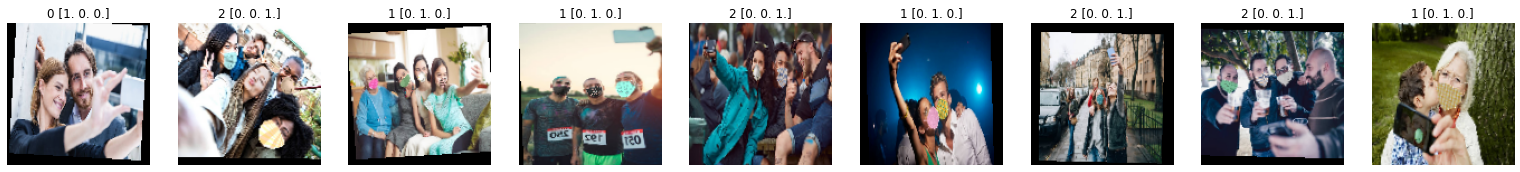

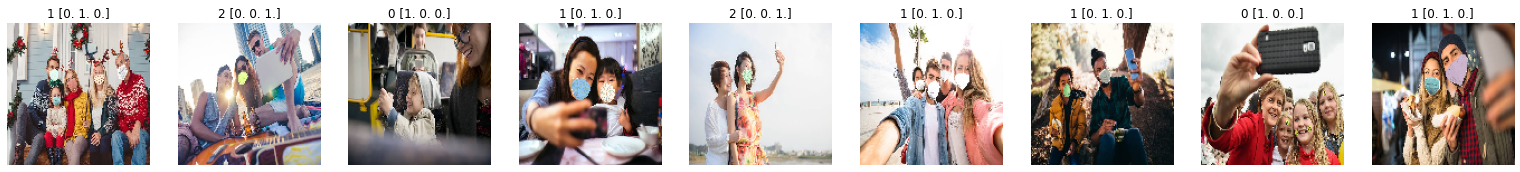

In [26]:
# plot to see and example result
import matplotlib.pyplot as plt

%matplotlib inline

dim_to_repeat = 2
repeats = 3



classes = [*train_gen.class_indices.keys()]



def printGrid(dt, num):
    plt.figure(figsize=(27, 6))
    iterator = iter(dt)
    for i in range(num):
        img, target = next(iterator)
        img = np.array(img[0]) * 255

        ax = plt.subplot(1, 9 ,i+1)
        plt.title(classes[tf.math.argmax(target[0]).numpy()] +" "+str(target[0].numpy()))
        
        if USE_GRAYSCALE:
            img = np.repeat(img, repeats, dim_to_repeat)
        plt.imshow(np.uint8(img))
        plt.axis("off")
        
    plt.plot()
    
printGrid(train_dataset, 9)

printGrid(valid_dataset, 9)



In [27]:


def appendCustomInception(ll, filters):
    # 1x1 convolution
    conv1_1 = keras.layers.Conv2D(filters, kernel_size=1, padding='same', activation='relu')(ll)

    # 3x3 convolution 
    conv3_3 = keras.layers.Conv2D(filters, kernel_size=1, padding='same', activation='relu')(ll)
    conv3_3 = keras.layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv3_3)

    # maxpool
    mp = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(ll)
    mp = keras.layers.Conv2D(filters, kernel_size=1, padding='same', activation='relu')(mp)

    return keras.layers.Concatenate()([conv1_1, conv3_3, mp])



#######################################################
inputs = keras.Input(target_shape)

# ll = last layer
# init block
ll = keras.layers.Conv2D(32, kernel_size=3, padding='same')(inputs)
ll = keras.layers.BatchNormalization()(ll)
ll = keras.layers.Activation('relu')(ll)
ll = keras.layers.MaxPool2D(pool_size=2, strides=2)(ll)

ll = keras.layers.Conv2D(64, kernel_size=3, padding='same')(inputs)
ll = keras.layers.BatchNormalization()(ll)
ll = keras.layers.Activation('relu')(ll)

for sz in [128, 256]:
    ll = appendCustomInception(ll, sz)
    print(ll.shape)

ll = keras.layers.MaxPool2D(pool_size=2, strides=2)(ll)
ll = keras.layers.GlobalAvgPool2D()(ll)
ll = keras.layers.BatchNormalization()(ll)
# classifier
ll = keras.layers.Dropout(0.4)(ll)

outputs = keras.layers.Dense(units=n_classes, activation='softmax')(ll)

model = keras.Model(inputs, outputs)

model.summary()

"""
# feature extraction
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=target_shape))
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)) 

model.add(keras.layers.Conv2D(96, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.Conv2D(96, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)) 

model.add(keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)) 

model.add(keras.layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)) 


#classifier
model.add(keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=256, activation='relu')) # , kernel_regularizer='l2')
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
#model.add(keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))

# print summary
model.summary()
"""

loss = keras.losses.CategoricalCrossentropy()

lr = 1e-4

opt = keras.optimizers.Adam(learning_rate=lr)
#opt = keras.optimizers.SGD(learning_rate=lr, momentum=0.09)

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])


(None, 128, 128, 384)
(None, 128, 128, 768)
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 128, 128, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 128, 128, 64) 256         conv2d_41[0][0]                  
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 128, 128, 64) 0           batch_normalization_10[0][0]     
___________________________________________

In [28]:
from datetime import datetime

now = datetime.now().strftime('%b%d_%H-%M-%S')


# setup callbacks
# -----------------------

callbacks = []

#model checkpoint

#callbacks.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'cp_{epoch:02d}.ckpt'), save_best_only=True, monitor='val_acc'))

# eraly stop
callbacks.append(
   tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
)

In [18]:

epochs = 15

history = model.fit(x=train_dataset,
          epochs=epochs,
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          callbacks=callbacks
          )

AttributeError: module 'tensorflow' has no attribute 'GPUOptions'

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# submit data
import os

from datetime import datetime

def create_csv(results, results_dir='./', prefix=''):

    csv_fname = prefix + 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')
    
    print("Created output "+ csv_fname)

    
def runTest(md, prefix =''):
    # load test set
    test_dir = os.path.join('/kaggle/input/maskdataset/MaskDataset', 'test')

    print(test_dir)

    test_data_gen = ImageDataGenerator(rescale=1/255.0)

    test_gen = test_data_gen.flow_from_directory(
        '/kaggle/input/maskdataset/MaskDataset',
        target_size=(img_w, img_h), 
        color_mode='rgb',
        class_mode='categorical',
        classes = ['test'],
        batch_size=1,
        shuffle=False
        )

    test_gen.reset()
    if USE_SATURATION:
        test_gen = test_gen.map(imgProcessing)

    predictions = md.predict_generator(test_gen, len(test_gen), verbose=1)

    results = {}

    images = test_gen.filenames
    i = 0

    for p in predictions:
      prediction = np.argmax(p)
      import ntpath
      image_name = ntpath.basename(images[i])
      results[image_name] = str(prediction)
      i = i + 1

    create_csv(results, '/kaggle/working', prefix)
 
loss, acc = model.evaluate(x=valid_dataset, verbose=2, steps=len(valid_gen))
a = "{:5.2f}".format(100*acc)
print("Last Model, accuracy: {:5.2f}%".format(100*acc))

runTest(model, 'last_' + a + "_")

In [ ]:
import glob

if os.path.exists(checkpoint_dir):
    list_of_files = glob.glob(checkpoint_dir+'/*') # * means all if need specific format then *.csv
    print(list_of_files)
    latest_file = max(list_of_files, key=os.path.getctime)
    
    print(latest_file)
    #reload model
    model.load_weights(os.path.join(checkpoint_dir, latest_file))
    
    loss, acc = model.evaluate(valid_dataset, verbose=2, steps=len(valid_gen))
    a = "{:5.2f}".format(100*acc)
    print("Best Model, accuracy: {:5.2f}%".format(100*acc))
    
    runTest(model, 'best_' + a + "_")